In [2]:

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
try:
    from create_feature_set import define_indicators_features
except:
    !wget https://raw.githubusercontent.com/Jpaku93/ML_Stock_Regression/main/create_feature_set.py
    from create_feature_set import define_indicators_features
    
def call_data(URL): ## function to call data TXT FILE
    data = pd.read_csv(URL, names=['time', 'open', 'high', 'low', 'close', 'volume'], delimiter = ";", index_col='time')
    data = data.drop_duplicates()

    return data

def apply_features(df):
    # store time variables
    time = df.index
    # get feature dataset
    features = define_indicators_features(df)
    features['time'] = pd.to_datetime(time)
    #set time as index
    features = features.set_index('time')
    return features

# get github txt file url
url = 'https://raw.githubusercontent.com/Jpaku93/ML_Stock_Regression/main/MES%2006-21.Last.txt'
data = call_data(url)[-10000:]
data = apply_features(data)
# drop rows with nan values
data = data.dropna()
data.head()

,open,high,low,close,volume,fast_ema,slow_ema,macd,signal,sma21,...,STDDEV,H-L,H-PC,L-PC,TR,ATR,TSI,BP,UO,COPP
time,,,,,,,,,,,,,,,,,,,,,
2021-06-08 06:12:00,4229.00,4229.00,4228.50,4228.50,15,4228.288511,4227.681069,0.607442,0.474599,4227.416667,...,1.022582,0.50,0.00,0.5,0.50,0.750000,0.250657,0.00,47.230017,0.000747
2021-06-08 06:13:00,4228.50,4228.50,4228.00,4228.25,62,4228.282586,4227.723212,0.559374,0.491554,4227.511905,...,0.868599,0.50,0.00,0.5,0.50,0.750000,0.229609,0.25,49.195883,0.000714
2021-06-08 06:14:00,4228.25,4228.75,4228.25,4228.25,72,4228.277573,4227.762234,0.515339,0.496311,4227.619048,...,0.575364,0.50,0.50,0.0,0.50,0.750000,0.213094,0.00,42.517007,0.000641
2021-06-08 06:15:00,4228.50,4228.50,4228.25,4228.50,35,4228.311792,4227.816883,0.494910,0.496031,4227.738095,...,0.312843,0.25,0.25,0.0,0.25,0.678571,0.206170,0.25,46.005924,0.000548
2021-06-08 06:16:00,4228.50,4228.50,4228.00,4228.25,89,4228.302286,4227.848966,0.453320,0.487489,4227.857143,...,0.284682,0.50,0.00,0.5,0.50,0.625000,0.190988,0.25,40.514456,0.000417


In [229]:
### import necessary Neural network packages 
import numpy as np 
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
import sklearn.metrics as sm
import tensorflow.keras.callbacks as cb
from keras.models import load_model
from math import exp, log

In [243]:
### define some global parameters
# "look back" days. This is the number of historical days we use to predict tomorrow. 
LB = 5
# number of epochs.
EPOCHS = 50


Epoch 1/50
197/197 [==============================] - 6s 14ms/step - loss: 0.0360 - val_loss: 7.8296e-04
Epoch 2/50
197/197 [==============================] - 2s 9ms/step - loss: 4.4212e-04 - val_loss: 9.9238e-04
Epoch 3/50
197/197 [==============================] - 2s 9ms/step - loss: 3.2472e-04 - val_loss: 6.5307e-04
Epoch 4/50
197/197 [==============================] - 2s 9ms/step - loss: 2.2667e-04 - val_loss: 5.1107e-04
Epoch 5/50
197/197 [==============================] - 2s 9ms/step - loss: 1.6078e-04 - val_loss: 2.2584e-04
Epoch 6/50
197/197 [==============================] - 2s 9ms/step - loss: 1.2292e-04 - val_loss: 1.1544e-04
Epoch 7/50
197/197 [==============================] - 2s 9ms/step - loss: 1.1026e-04 - val_loss: 1.0798e-04
Epoch 8/50
197/197 [==============================] - 2s 10ms/step - loss: 1.0433e-04 - val_loss: 1.0291e-04
Epoch 9/50
197/197 [==============================] - 2s 9ms/step - loss: 1.0809e-04 - val_loss: 1.0729e-04
Epoch 10/50
197/197 [=========

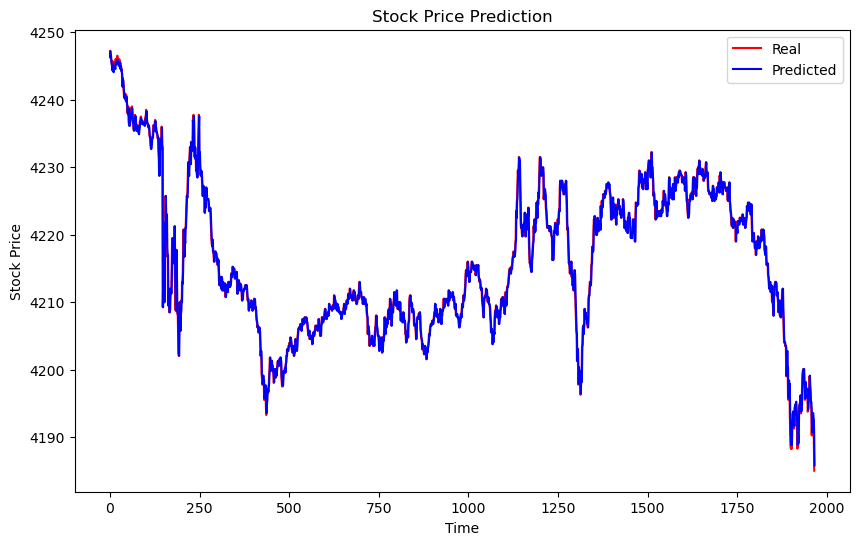

In [244]:
# Create an RNN LSTM model class to predict the price of a stock
class RNN_LSTM_price_prediction:
    def __init__(self, data, LB, EPOCHS):
        self.data = data
        self.LB = LB
        self.EPOCHS = EPOCHS
        self.model = None
        self.scaler = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.X_train_scaled = None
        self.y_train_scaled = None
        self.X_test_scaled = None
        self.y_test_scaled = None

    def split_data(self, test_size=0.2):
        # split data into train and test set
        self.X_train = self.data.iloc[:-int(len(self.data) * test_size), :]
        self.y_train = self.data.iloc[1:-int(len(self.data) * test_size) + 1, 0]
        self.X_test = self.data.iloc[-int(len(self.data) * test_size):, :]
        self.y_test = self.data.iloc[-int(len(self.data) * test_size) + 1:, 0]
        
    
    def scale_data(self):
        # scale data
        from sklearn.preprocessing import MinMaxScaler
        self.scaler = MinMaxScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.y_train_scaled = self.scaler.fit_transform(self.y_train.values.reshape(-1, 1))
        self.X_test_scaled = self.scaler.fit_transform(self.X_test)
        self.y_test_scaled = self.scaler.fit_transform(self.y_test.values.reshape(-1, 1))
        
    def create_model(self):
        # create model
        self.model = Sequential()
        self.model.add(LSTM( units=50, return_sequences=True, input_shape=(self.X_train_scaled.shape[1], 1)))
        self.model.add(LSTM(units=50, return_sequences=True))
        self.model.add(LSTM(units=50))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam')
        
    def train_model(self):
        # train model
        self.model.fit(
            self.X_train_scaled.reshape(self.X_train_scaled.shape[0], self.X_train_scaled.shape[1], 1),
            self.y_train_scaled,
            epochs=self.EPOCHS,
            batch_size=32,
            verbose=1,
            validation_split=0.2,
            callbacks=[cb.EarlyStopping(monitor='val_loss', patience=10)]
        )
        
        
    def predict(self):
        # predict
        self.y_pred = self.model.predict(self.X_test_scaled.reshape(self.X_test_scaled.shape[0], self.X_test_scaled.shape[1], 1))
        self.y_pred = self.scaler.inverse_transform(self.y_pred)
        self.y_test = self.scaler.inverse_transform(self.y_test_scaled)

        
    def plot(self):
        # plot
        plt.figure(figsize=(10, 6))
        plt.plot(self.y_test, color='red', label='Real')
        plt.plot(self.y_pred, color='blue', label='Predicted')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
        
    def run(self):
        self.split_data()
        self.scale_data()
        self.create_model()
        self.train_model()
        self.predict()
        self.plot()
        

# create an instance of the class
rnn_lstm = RNN_LSTM_price_prediction(data['close'].to_frame(), LB, EPOCHS)
rnn_lstm.run()


In [245]:
# get a prediction for the next day
def predict_next_day(model, data, LB):
    # get the last LB days
    last_LB_days = data[-LB:]
    # scale the data
    last_LB_days_scaled = model.scaler.transform(last_LB_days)
    # predict the next day
    prediction = model.model.predict(last_LB_days_scaled.reshape(1, LB, 1))
    # unscale the prediction
    prediction = model.scaler.inverse_transform(prediction)
    return prediction




# predict

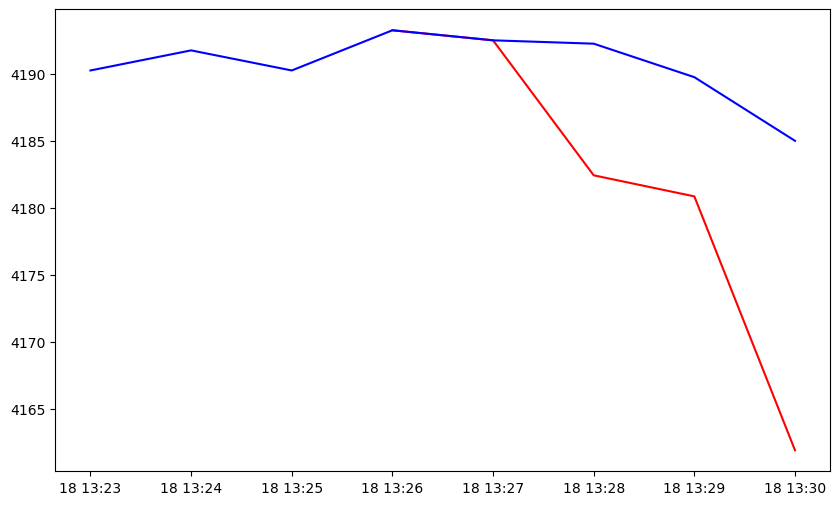

In [256]:
predict_days = 3


Test_Actual_data =  data['close'].tail(LB + predict_days).to_frame()
# get the last 30 rows of the data
last_30_days = Test_Actual_data['close'].tail(predict_days).to_frame()
# cut the last 30 rows of the data
pred_days = pd.DataFrame(index=last_30_days.index, columns=['close'])
pred_days
# concatenate the last 30 rows of the data with the predicted 30 days
pred_days = pd.concat([Test_Actual_data[:-predict_days],pred_days])



for i in range(predict_days):
    # Test_Prediction_data.at[Test_Prediction_data.index[-predict_days], 'close'] = predict_next_day(rnn_lstm, Test_Prediction_data[:-predict_days].values, LB).flatten()[0]
    pred_days.at[ pred_days.index[-predict_days+i], 'close'] = predict_next_day(rnn_lstm, pred_days[:-predict_days+i].values, LB).flatten()[0]
    pred_days = pred_days[1:]

# plot the prediction
plt.figure(figsize=(10, 6))
plt.plot(pred_days['close'], color='red', label='Real')
plt.plot(Test_Actual_data['close'], color='blue', label='Predicted')